In [19]:
import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

In [20]:
# 喷管长度
L=3
# 空气的Gamma
Gamma=1.4
# 空间步长
N=31
# 柯朗数
C=0.5
# 时间步数
K=5000
pe=0.93

In [21]:
dx=L/(N-1)

In [32]:
x_init=np.linspace(0,L,N).reshape(1,-1)
print(x_init)

[[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
  1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]]


In [28]:
A_np=np.append((1+2.2*(x_init[x_init<=L/2]-1.5)**2),(1+0.2223*(x_init[x_init>L/2]-1.5)**2))
print(A_np)

[5.95     5.312    4.718    4.168    3.662    3.2      2.782    2.408
 2.078    1.792    1.55     1.352    1.198    1.088    1.022    1.
 1.002223 1.008892 1.020007 1.035568 1.055575 1.080028 1.108927 1.142272
 1.180063 1.2223   1.268983 1.320112 1.375687 1.435708 1.500175]


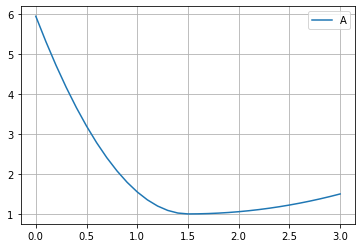

In [24]:
plt.plot(np.linspace(0,L,N),A_np,label="A")
plt.legend()
plt.grid()
plt.show()

In [45]:
# 初值
A=pd.Series(A_np,index=np.linspace(0,L,N))
rou_result=pd.DataFrame(1-0.023*x_init,columns=np.linspace(0,L,N))
T_result=pd.DataFrame(1-0.009333*x_init,columns=np.linspace(0,L,N))
V_result=pd.DataFrame((0.05+0.11*x_init)*np.sqrt(1-0.2314*x_init),columns=np.linspace(0,L,N))
print(V_result)
p_result=rou_result*T_result
lnA=np.log(A)

    0.0      0.1       0.2       0.3       0.4       0.5       0.6      0.7  \
0  0.05  0.06029  0.070314  0.080067  0.089544  0.098739  0.107646  0.11626   

        0.8      0.9  ...       2.1       2.2       2.3       2.4    2.5  \
0  0.124574  0.13258  ...  0.201471  0.204592  0.207235  0.209379  0.211   

        2.6       2.7       2.8       2.9       3.0  
0  0.212069  0.212556  0.212424  0.211634  0.210137  

[1 rows x 31 columns]


In [34]:
K = 1
for k in range(K):
    if k % 500==0:
        print(k/50)
    rou = rou_result.iloc[-1]
    T = T_result.iloc[-1]
    V = V_result.iloc[-1]
    dt = (C * dx / (V + np.sqrt(T))).min()
    print(rou)
    print(T)
    print(V)
    print('-----------------origin-------------')
    # 预估步
    drou_est = -(V * (rou.shift(-1) - rou) + rou * (V.shift(-1) - V) + rou * V * (lnA.shift(-1) - lnA)) / dx
    dV_est = -(V * (V.shift(-1) - V) + ((T.shift(-1) - T) + (rou.shift(-1) - rou) * T / rou) / Gamma) / dx
    dT_est = -(V * (T.shift(-1) - T) + (Gamma - 1) * T * ((V.shift(-1) - V) + V * (lnA.shift(-1) - lnA))) / dx

    print(drou_est)
    print(dV_est)
    print(dT_est)
    print('-------')
    rou_est = rou + drou_est * dt
    V_est = V + dV_est * dt
    T_est = T + dT_est * dt

    # 校正步
    drou_rev = (-V_est * (rou_est - rou_est.shift(1)) - rou_est * (V_est - V_est.shift(1)) - rou_est * V_est * (
                lnA - lnA.shift(1))) / dx
    dV_rev = -(V_est * (V_est - V_est.shift(1)) + (
                (T_est - T_est.shift(1)) + (rou_est - rou_est.shift(1)) * T_est / rou_est) / Gamma) / dx
    dT_rev = -(V_est * (T_est - T_est.shift(1)) + (Gamma - 1) * T_est * (
                (V_est - V_est.shift(1)) + V_est * (lnA - lnA.shift(1)))) / dx

    drou_av = (drou_est + drou_rev) / 2
    dV_av = (dV_est + dV_rev) / 2
    dT_av = (dT_est + dT_rev) / 2

    rou_rev = rou + drou_av * dt
    V_rev = V + dV_av * dt
    T_rev = T + dT_av * dt
    p_rev = rou_rev * T_rev

    # 边界条件
    p_rev.iloc[0] = 1
    p_rev.iloc[-1] = pe

    V_rev.iloc[0] = V_rev.iloc[1] * 2 - V_rev.iloc[2]
    V_rev.iloc[-1] = V_rev.iloc[-2] * 2 - V_rev.iloc[-3]

    rou_rev.iloc[0] = 1
    rou_rev.iloc[-1] = rou_rev.iloc[-2] * 2 - rou_rev.iloc[-3]

    T_rev.iloc[0] = 1
    T_rev.iloc[-1] = pe/rou_rev.iloc[-1]

    # 将结果拼接到表格下行
    rou_rev.name = rou_result.index[-1] + dt
    rou_result = rou_result.append(rou_rev)

    V_rev.name = V_result.index[-1] + dt
    V_result = V_result.append(V_rev)

    T_rev.name = T_result.index[-1] + dt
    T_result = T_result.append(T_rev)

    p_rev.name = p_result.index[-1] + dt
    p_result = p_result.append(p_rev)
    print(rou_rev)
    print(V_rev)
    print(T_rev)
    

0.0
0.0    1.0000
0.1    0.9977
0.2    0.9954
0.3    0.9931
0.4    0.9908
0.5    0.9885
0.6    0.9862
0.7    0.9839
0.8    0.9816
0.9    0.9793
1.0    0.9770
1.1    0.9747
1.2    0.9724
1.3    0.9701
1.4    0.9678
1.5    0.9655
1.6    0.9632
1.7    0.9609
1.8    0.9586
1.9    0.9563
2.0    0.9540
2.1    0.9517
2.2    0.9494
2.3    0.9471
2.4    0.9448
2.5    0.9425
2.6    0.9402
2.7    0.9379
2.8    0.9356
2.9    0.9333
3.0    0.9310
Name: 0, dtype: float64
0.0    1.000000
0.1    0.999067
0.2    0.998133
0.3    0.997200
0.4    0.996267
0.5    0.995333
0.6    0.994400
0.7    0.993467
0.8    0.992534
0.9    0.991600
1.0    0.990667
1.1    0.989734
1.2    0.988800
1.3    0.987867
1.4    0.986934
1.5    0.986001
1.6    0.985067
1.7    0.984134
1.8    0.983201
1.9    0.982267
2.0    0.981334
2.1    0.980401
2.2    0.979467
2.3    0.978534
2.4    0.977601
2.5    0.976668
2.6    0.975734
2.7    0.974801
2.8    0.973868
2.9    0.972934
3.0    0.972001
Name: 0, dtype: float64
0.0    0.050000
0.

In [35]:
Ma_result=V_result/np.sqrt(T_result)

/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 21897 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 36947 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 22788 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 21508 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 27969 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: 

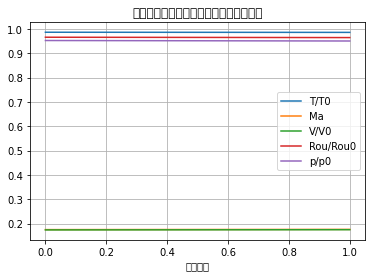

In [36]:
plt.plot(range(K+1),T_result[1.5].values,label="T/T0")
plt.plot(range(K+1),Ma_result[1.5].values,label="Ma")
plt.plot(range(K+1),V_result[1.5].values,label="V/V0")
plt.plot(range(K+1),rou_result[1.5].values,label="Rou/Rou0")
plt.plot(range(K+1),p_result[1.5].values,label="p/p0")
plt.xlabel('时间步数')
plt.title('喉道处各流动参数随时间推进步数的变化')
plt.grid()
plt.legend()
plt.show()


/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 20986 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 21475 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 22788 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 21508 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 27969 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: 

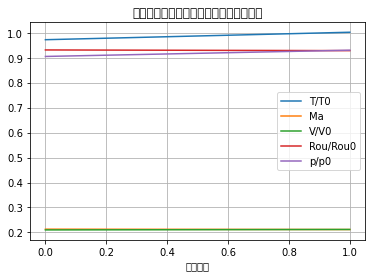

In [37]:
plt.plot(range(K+1),T_result[3].values,label="T/T0")
plt.plot(range(K+1),Ma_result[3].values,label="Ma")
plt.plot(range(K+1),V_result[3].values,label="V/V0")
plt.plot(range(K+1),rou_result[3].values,label="Rou/Rou0")
plt.plot(range(K+1),p_result[3].values,label="p/p0")
plt.xlabel('时间步数')
plt.title('出口处各流动参数随时间推进步数的变化')
plt.grid()
plt.legend()
plt.show()

In [38]:
Mae=sqrt((pe**((-Gamma+1)/Gamma)-1)*2/(Gamma-1))

In [39]:
A_=A.iloc[-1]/sqrt(Mae**(-2)*(2/(Gamma+1)*(1+(Gamma-1)/2*Mae**2))**((Gamma+1)/(Gamma-1)))
A_

0.7884202473523074

In [40]:
# 计算精确解
Ma_exact=[]
from scipy.optimize import fsolve
for i in range(N):
    x=dx*i
    global thisA
    thisA=A_np[i]
    def func(i):
        global thisA
        Ma = i[0]
        return [(thisA/A_)**2-Ma**(-2)*(2/(Gamma+1)*(1+(Gamma-1)/2*Ma**2))**((Gamma+1)/(Gamma-1))]
    Ma_exact.append(fsolve(func,[Ma_result.iloc[-1,i]])[0])

In [41]:
Ma_exact

[0.07695543959255048,
 0.08627682891914563,
 0.09725647260517527,
 0.11026834445309844,
 0.125780021784374,
 0.14437236197967512,
 0.16675654163419423,
 0.19377853840075854,
 0.22638914110945477,
 0.2655342466993903,
 0.3118779631623618,
 0.3652045086306058,
 0.42327868855880163,
 0.480057986663648,
 0.5241482972446929,
 0.5412497522824213,
 0.5394561025717843,
 0.5341664380698946,
 0.525640461165913,
 0.5142684235013777,
 0.5005208142898212,
 0.48489806725203327,
 0.46788924890220157,
 0.44994354996380503,
 0.4314542373372383,
 0.41275250997375373,
 0.3941081423878464,
 0.37573417317591373,
 0.35779359736711747,
 0.3404067088739081,
 0.3236582804258109]

In [42]:
Ma_exact=np.array(Ma_exact)
p_exact=(1+(Gamma-1)/2*np.array(Ma_exact)**2)**(-Gamma/(Gamma-1))
rou_exact=(1+(Gamma-1)/2*Ma_exact**2)**(-1/(Gamma-1))
T_exact=(1+(Gamma-1)/2*np.array(Ma_exact)**2)**(-1)
V_exact=Ma_exact*np.sqrt(T_exact)

In [43]:
p_exact

array([0.99586553, 0.99480682, 0.99340691, 0.99153499, 0.98900396,
       0.98554545, 0.9807757 , 0.97415303, 0.96493571, 0.95217052,
       0.9347897 , 0.9119788 , 0.88406856, 0.85409598, 0.82926585,
       0.81931777, 0.82036882, 0.82345818, 0.82840448, 0.83493591,
       0.84272638, 0.85143204, 0.86072155, 0.87029712, 0.87990634,
       0.88934632, 0.8984625 , 0.90714417, 0.91531828, 0.92294276,
       0.93      ])

/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 31283 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 23450 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 26102 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 21508 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 27969 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/mnt/d/my_app/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: 

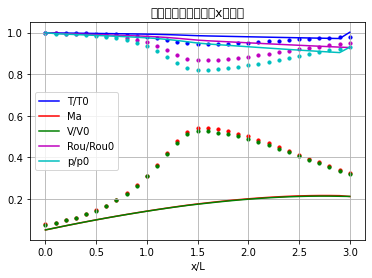

In [44]:
colors=['b','r','g','m','c']


plt.plot(np.linspace(0,L,N),T_result.iloc[-1],label="T/T0",color=colors[0])
plt.plot(np.linspace(0,L,N),Ma_result.iloc[-1],label="Ma",color=colors[1])
plt.plot(np.linspace(0,L,N),V_result.iloc[-1],label="V/V0",color=colors[2])
plt.plot(np.linspace(0,L,N),rou_result.iloc[-1],label="Rou/Rou0",color=colors[3])
plt.plot(np.linspace(0,L,N),p_result.iloc[-1],label="p/p0",color=colors[4])
plt.xlabel('x/L')
plt.title('稳定时各流动参数随x的变化')
plt.grid()
plt.legend()

plt.scatter(np.linspace(0,L,N),T_exact,color=colors[0],s=10)
plt.scatter(np.linspace(0,L,N),Ma_exact,color=colors[1],s=10)
plt.scatter(np.linspace(0,L,N),V_exact,color=colors[2],s=10)
plt.scatter(np.linspace(0,L,N),rou_exact,color=colors[3],s=10)
plt.scatter(np.linspace(0,L,N),p_exact,color=colors[4],s=10)
plt.show()